In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from warnings import filterwarnings
import matplotlib.pyplot as plt


filterwarnings("ignore")

from quant_invest_lab.data_provider import download_crypto_historical_data
from modules.filters import fft_smoothing, fft_detrending

In [25]:
SYMBOL = "BTC-USDT"
TIMEFRAME = "1hour"
df = download_crypto_historical_data(SYMBOL, TIMEFRAME).iloc[-3000:]

df.dropna(inplace=True)
print(df.shape)
df.head()

(3000, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns
Date,,,,,,,,
2023-01-16 12:00:00,1.673867e+09,20846.6,20816.1,20857.2,20782.2,158.413103,3.298596e+06,-0.001453
2023-01-16 13:00:00,1.673870e+09,20816.0,20786.8,20870.8,20778.8,148.391608,3.089712e+06,-0.001408
2023-01-16 14:00:00,1.673874e+09,20786.9,20824.1,20867.0,20771.9,303.138800,6.311379e+06,0.001794
2023-01-16 15:00:00,1.673878e+09,20824.1,20859.5,20886.5,20756.5,429.891252,8.962930e+06,0.001700
2023-01-16 16:00:00,1.673881e+09,20859.5,20995.5,21062.1,20619.0,774.687591,1.615996e+07,0.006520


In [26]:
df["Close_denoised_fft"] = fft_smoothing(df.Close, frequency_cutoff=0.01)
df["Close_detrended_fft"] = fft_detrending(df.Close, frequency_cutoff=0.01)

# Fourrier Tranformation


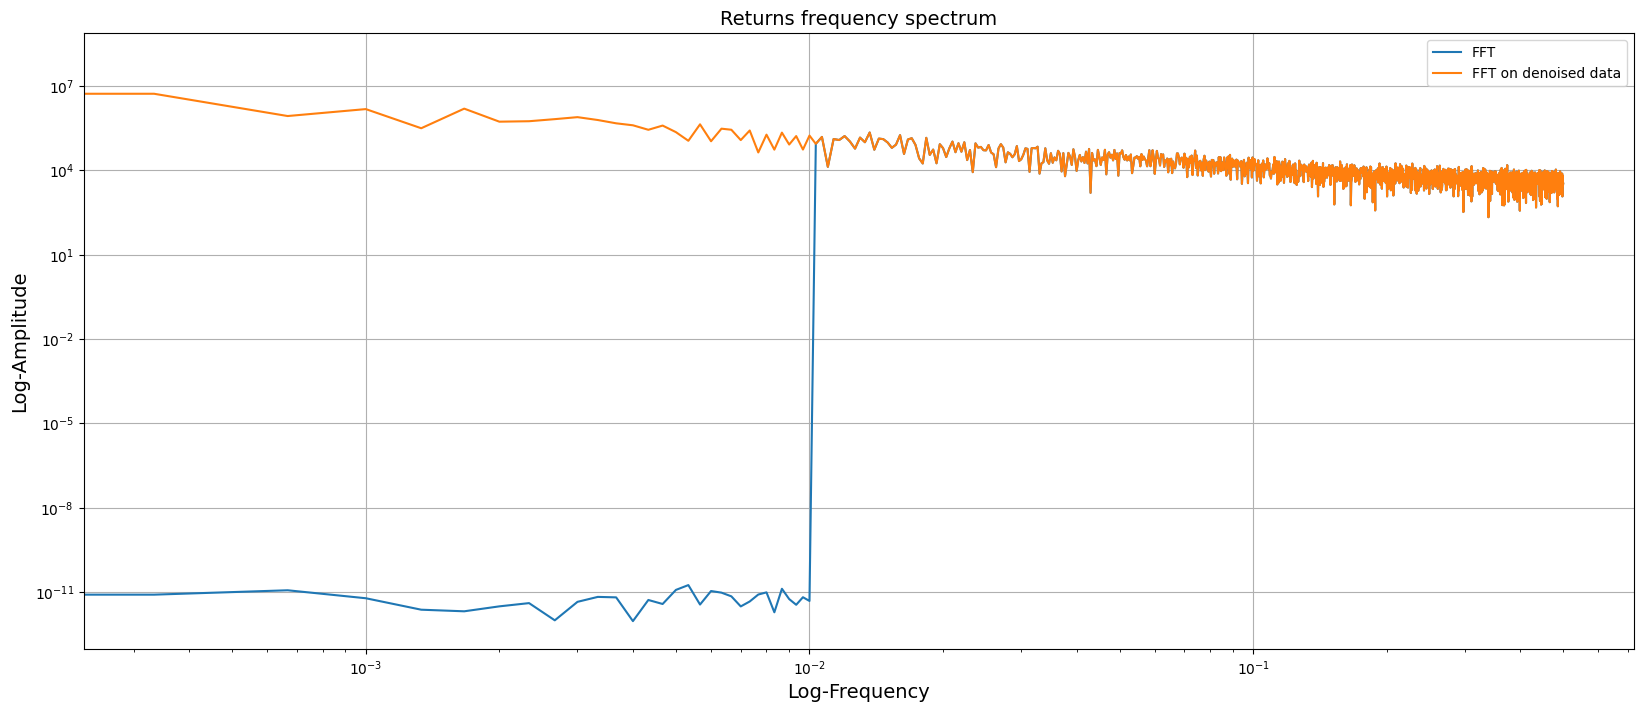

In [29]:
def construct_fft(
    yvalues, real_abs_only: bool = True
) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    N = yvalues.shape[0]
    fft_y = np.fft.fft(yvalues)
    fft_x = np.fft.fftfreq(N)
    if real_abs_only:
        fft_x = fft_x[: len(fft_x) // 2]
        fft_y = np.abs(fft_y[: len(fft_y) // 2])
    return fft_x, fft_y


fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title("Returns frequency spectrum", fontsize=14)
ax.set_ylabel("Log-Amplitude", fontsize=14)
ax.set_xlabel("Log-Frequency", fontsize=14)

fft_x, fft_y = construct_fft(
    df["Close_detrended_fft"].to_numpy(),
)
ax.plot(fft_x, fft_y, label="FFT")
fft_x_smooth, fft_y_smooth = construct_fft(
    df["Close"].to_numpy(),
)
ax.plot(fft_x_smooth, fft_y_smooth, label="FFT on denoised data")
plt.xscale("log")
plt.yscale("log")
ax.grid()
ax.legend()
plt.show()

In [30]:
fig = make_subplots(
    rows=1,
    cols=1,
    specs=[
        [{"secondary_y": True}]
    ],  # , subplot_titles=("Fourrier and raw data comparing")
)

fig.add_trace(
    go.Scatter(
        name="Price data (close)",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Close_detrended_fft",
        x=df.index,
        y=df["Close_detrended_fft"],
    ),
    row=1,
    col=1,
    secondary_y=True,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Comparing price and detrended price",
    height=600,
)

# Set x-axis title
fig.update_xaxes(title_text="Datetime")

# Set y-axes titles
fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Detrended price", secondary_y=True)

In [31]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Close_denoised_fft data",
        x=df.index,
        y=df["Close_denoised_fft"],
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Comparing price and denoised price",
)